# Part 1

1.

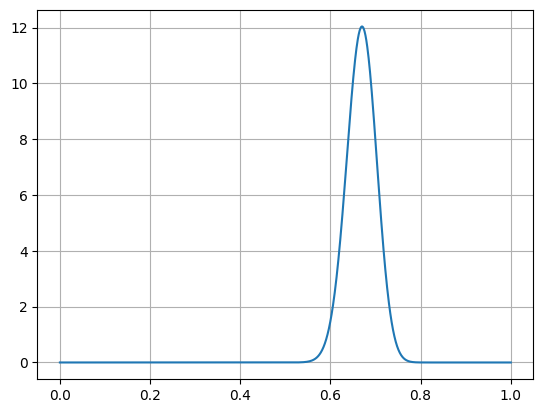

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
theta=np.linspace(0,1,1000)
posterior_pdf=beta.pdf(theta,135,67)
plt.plot(theta,posterior_pdf)
plt.grid(True)


2.

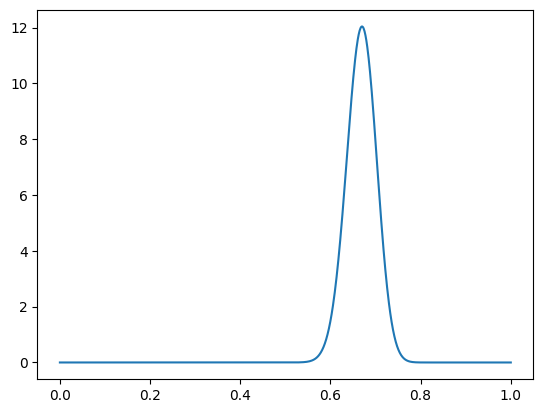

In [13]:
mu_grid=np.linspace(0,1,1000)
prior=np.ones(1000)
likelihood=np.ones(1000)
data=np.array([10,15,15,14,14,14,13,11,12,16])
n=20
for y in data:
    likelihood*=(mu_grid**y)*((1-mu_grid)**(n-y))
unnormalized=prior*likelihood
posterior=unnormalized/np.trapz(unnormalized,mu_grid)
plt.plot(mu_grid,posterior)

3.

In [14]:

samples=10000
theta_samples=np.random.beta(1,1,samples)
likelihoods=np.ones(samples)
for y in data:
    likelihoods*=(theta_samples**y)*((1-theta_samples)**(n-y))
marginal_likelihood=np.mean(likelihoods)
marginal_likelihood


7.057857862903206e-57

4.

In [16]:
import pandas as pd
N=10000
theta_prop=np.random.beta(3,3,N)
prior_density=beta.pdf(theta_prop,1,1)
proposal_density=beta.pdf(theta_prop,3,3)
likelihoods=np.ones(N)
for y in data:
    likelihoods*=(theta_prop**y)*((1-theta_prop)**(n-y))
weights=(likelihoods*prior_density)/proposal_density
weights_normalized=weights/np.sum(weights)
df=pd.DataFrame({
    'theta': theta_prop,
    'weight': weights_normalized
})
posterior_samples=df.sample(n=N//4,weights='weight',replace=True).reset_index(drop=True)
posterior_samples.head()


,theta,weight
0,0.712665,0.000413
1,0.704632,0.000540
2,0.690722,0.000739
3,0.706551,0.000510
4,0.678060,0.000838


5.

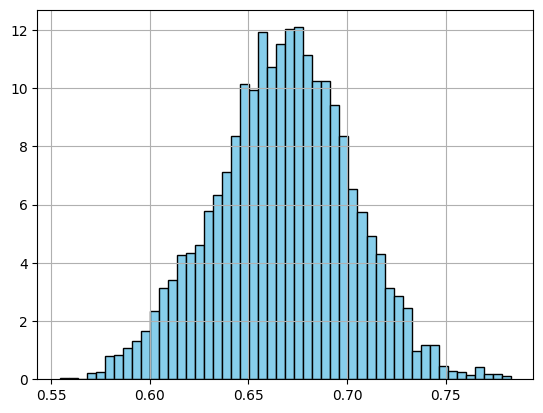

In [22]:
def metropolis_hastings(posterior_logpdf, proposal_sampler, proposal_logpdf, init_theta, n_samples):
    samples = [init_theta]
    current_theta = init_theta
    current_log_prob = posterior_logpdf(current_theta)
    for i in range(n_samples - 1):
        proposed_theta = proposal_sampler(current_theta)
        proposed_log_prob = posterior_logpdf(proposed_theta)
        log_accept_ratio = proposed_log_prob - current_log_prob + \
                           proposal_logpdf(current_theta, proposed_theta) - proposal_logpdf(proposed_theta, current_theta)
        if np.log(np.random.rand()) < log_accept_ratio:
            samples.append(proposed_theta)
            current_theta = proposed_theta
            current_log_prob = proposed_log_prob
        else:
            samples.append(current_theta)
    return np.array(samples)

def posterior_logpdf(theta):
    if theta <= 0 or theta >= 1:
        return -np.inf
    log_likelihood = np.sum([y * np.log(theta) + (n - y) * np.log(1 - theta) for y in data])
    log_prior = 0
    return log_likelihood + log_prior

proposal_std = 0.02
proposal_sampler = lambda theta: np.clip(np.random.normal(theta, proposal_std), 0.001, 0.999)
proposal_logpdf = lambda x, y: 0
init_theta = 0.5
n_samples = 10000
mh_samples = metropolis_hastings(posterior_logpdf, proposal_sampler, proposal_logpdf, init_theta, n_samples)
burn_in = 2000
mh_samples_post_burnin = mh_samples[burn_in:]
plt.hist(mh_samples_post_burnin, bins=50, density=True, color='skyblue', edgecolor='black', label='MCMC Posterior Samples')
plt.grid(True)

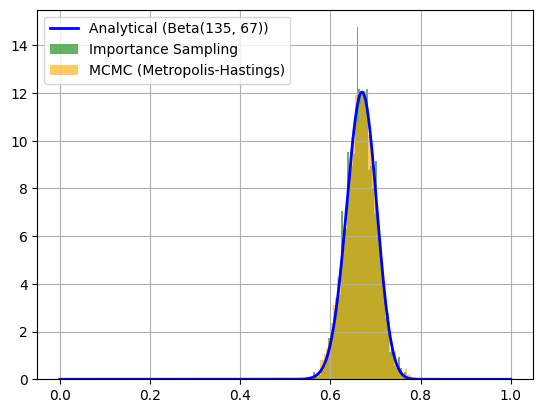

In [24]:
theta_grid = np.linspace(0, 1, 1000)
analytical_pdf = beta.pdf(theta_grid, 135, 67)
plt.plot(theta_grid, analytical_pdf, label='Analytical (Beta(135, 67))', color='blue', linewidth=2)
plt.hist(posterior_samples['theta'], bins=50, density=True, alpha=0.6, label='Importance Sampling', color='green')
plt.hist(mh_samples_post_burnin, bins=50, density=True, alpha=0.6, label='MCMC (Metropolis-Hastings)', color='orange')
plt.legend()
plt.grid(True)


# Part 2

1.

Posterior mean of alpha: 419.40536543296764
Posterior SD of alpha: 0.7468045282508016
Posterior mean of beta: 51.73546991152782
Posterior SD of beta: 1.0078218225322264


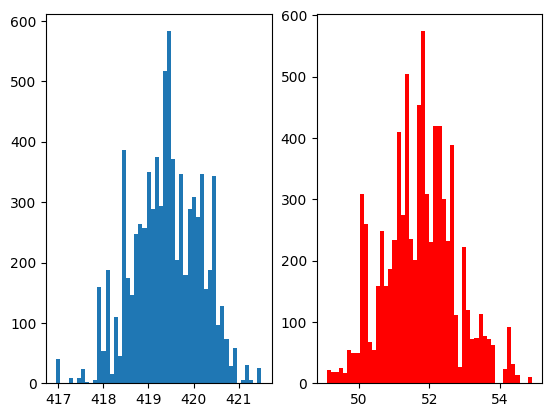

In [27]:
from scipy.stats import truncnorm, norm
url = "https://raw.githubusercontent.com/yadavhimanshu059/CGS698C/main/notes/Data/word-recognition-times.csv"
data = pd.read_csv(url)
data = data.iloc[:, 1:]
data.columns = ['type', 'RT']
data['type'] = data['type'].map({'word': 0, 'non-word': 1})
RT = data['RT'].values
type_i = data['type'].values
sigma = 30

def log_posterior(alpha, beta, RT, type_i):
    if beta < 0:
        return -np.inf
    mu_i = alpha + beta * type_i
    log_likelihood = np.sum(norm.logpdf(RT, loc=mu_i, scale=sigma))
    log_prior_alpha = norm.logpdf(alpha, loc=400, scale=50)
    log_prior_beta = truncnorm.logpdf(beta, a=0, b=np.inf, loc=0, scale=50)
    return log_likelihood + log_prior_alpha + log_prior_beta

def run_mcmc(n_samples, init_alpha=400, init_beta=10, proposal_std_alpha=5, proposal_std_beta=5):
    alpha_samples = [init_alpha]
    beta_samples = [init_beta]
    
    current_alpha = init_alpha
    current_beta = init_beta
    current_log_post = log_posterior(current_alpha, current_beta, RT, type_i)
    
    for _ in range(n_samples - 1):
        prop_alpha = np.random.normal(current_alpha, proposal_std_alpha)
        prop_beta = np.random.normal(current_beta, proposal_std_beta)
        
        prop_log_post = log_posterior(prop_alpha, prop_beta, RT, type_i)
        log_accept_ratio = prop_log_post - current_log_post
        
        if np.log(np.random.rand()) < log_accept_ratio:
            current_alpha = prop_alpha
            current_beta = prop_beta
            current_log_post = prop_log_post
        
        alpha_samples.append(current_alpha)
        beta_samples.append(current_beta)
    
    return np.array(alpha_samples), np.array(beta_samples)

n_samples = 10000
alpha_chain, beta_chain = run_mcmc(n_samples)

burn_in = 2000
alpha_post = alpha_chain[burn_in:]
beta_post = beta_chain[burn_in:]

print("Posterior mean of alpha:", np.mean(alpha_post))
print("Posterior SD of alpha:", np.std(alpha_post))
print("Posterior mean of beta:", np.mean(beta_post))
print("Posterior SD of beta:", np.std(beta_post))

plt.subplot(1, 2, 1)
plt.hist(alpha_post, bins=50)

plt.subplot(1, 2, 2)
plt.hist(beta_post, bins=50, color='red')
plt.show()


2.

In [28]:
alpha_credible_interval = np.quantile(alpha_post, [0.025, 0.975])
print("95% credible interval for α:", alpha_credible_interval)
beta_credible_interval = np.quantile(beta_post, [0.025, 0.975])
print("95% credible interval for β:", beta_credible_interval)

95% credible interval for α: [417.95598635 420.70376203]
95% credible interval for β: [49.88993653 53.81803756]


# Part 3

1.

C:\Users\nakul\AppData\Local\Temp\ipykernel_30340\3150067047.py:43: RuntimeWarning: overflow encountered in exp
  accept_prob = np.exp(current_V + current_T - proposed_V - proposed_T)


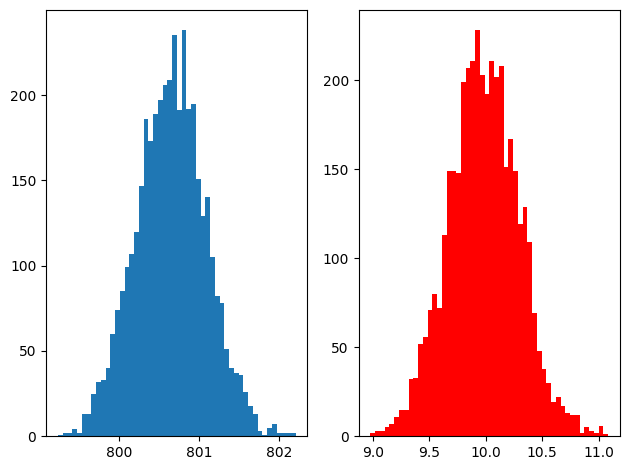

95% CI for μ: [799.78566351 801.52071892]
95% CI for σ: [ 9.3672691  10.61188861]


In [30]:
true_mu = 800
true_var = 100
y = np.random.normal(loc=true_mu, scale=np.sqrt(true_var), size=500)

def gradient(mu, sigma, y, n, m, s, a, b):
    grad_mu = (((n * mu) - np.sum(y)) / sigma**2) + ((mu - m) / s**2)
    grad_sigma = (n / sigma) - (np.sum((y - mu)**2) / sigma**3) + ((sigma - a) / b**2)
    return np.array([grad_mu, grad_sigma])

def V(mu, sigma, y, n, m, s, a, b):
    log_likelihood = np.sum(norm.logpdf(y, loc=mu, scale=sigma))
    log_prior_mu = norm.logpdf(mu, loc=m, scale=s)
    log_prior_sigma = norm.logpdf(sigma, loc=a, scale=b)
    return -1 * (log_likelihood + log_prior_mu + log_prior_sigma)

def HMC(y, n, m, s, a, b, step, L, initial_q, nsamp, nburn):
    mu_chain = np.zeros(nsamp)
    sigma_chain = np.zeros(nsamp)
    mu_chain[0], sigma_chain[0] = initial_q
    i = 0
    while i < nsamp - 1:
        q = np.array([mu_chain[i], sigma_chain[i]])
        p = np.random.normal(0, 1, size=2)
        current_q = np.copy(q)
        current_p = np.copy(p)

        current_V = V(q[0], q[1], y, n, m, s, a, b)
        current_T = np.sum(p**2) / 2

        # Leapfrog integration
        p -= 0.5 * step * gradient(q[0], q[1], y, n, m, s, a, b)
        for _ in range(L):
            q += step * p
            if _ != L - 1:
                p -= step * gradient(q[0], q[1], y, n, m, s, a, b)
        p -= 0.5 * step * gradient(q[0], q[1], y, n, m, s, a, b)

        proposed_q = q
        proposed_p = p
        proposed_V = V(proposed_q[0], proposed_q[1], y, n, m, s, a, b)
        proposed_T = np.sum(proposed_p**2) / 2

        accept_prob = np.exp(current_V + current_T - proposed_V - proposed_T)
        if np.random.rand() < min(1, accept_prob):
            mu_chain[i+1] = proposed_q[0]
            sigma_chain[i+1] = proposed_q[1]
        else:
            mu_chain[i+1] = mu_chain[i]
            sigma_chain[i+1] = sigma_chain[i]
        i += 1

    return mu_chain[nburn:], sigma_chain[nburn:]

mu_post, sigma_post = HMC(
    y=y, n=len(y),
    m=1000, s=20,
    a=10, b=2,
    step=0.02, L=12,
    initial_q=[1000, 11],
    nsamp=6000, nburn=2000
)

plt.subplot(1, 2, 1)
plt.hist(mu_post, bins=50)

plt.subplot(1, 2, 2)
plt.hist(sigma_post, bins=50, color='red')
plt.tight_layout()
plt.show()
mu_ci = np.quantile(mu_post, [0.025, 0.975])
sigma_ci = np.quantile(sigma_post, [0.025, 0.975])
print("95% CI for μ:", mu_ci)
print("95% CI for σ:", sigma_ci)


2.

C:\Users\nakul\AppData\Local\Temp\ipykernel_30340\3150067047.py:43: RuntimeWarning: overflow encountered in exp
  accept_prob = np.exp(current_V + current_T - proposed_V - proposed_T)


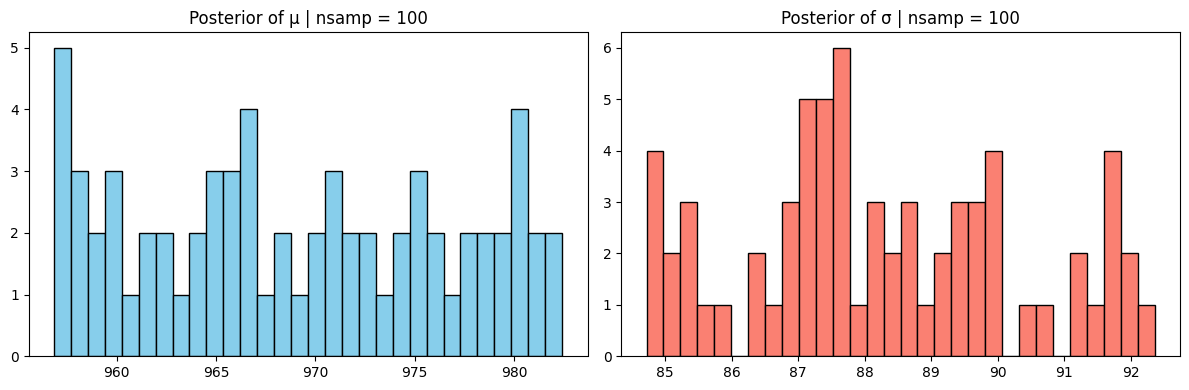

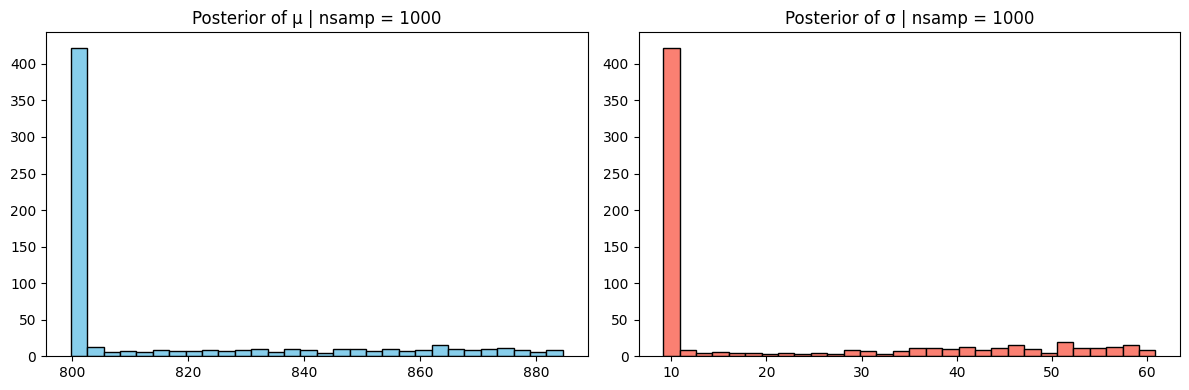

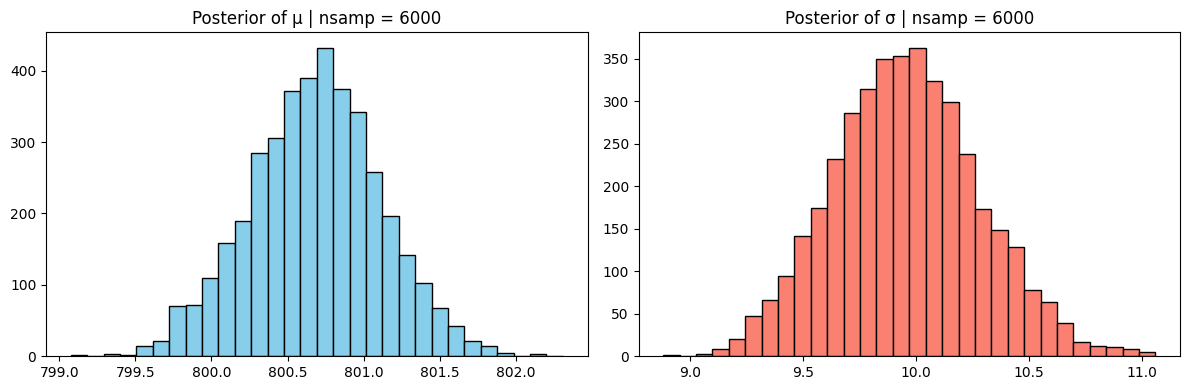

In [31]:
sample_sizes = [100, 1000, 6000]

for nsamp in sample_sizes:
    nburn = nsamp // 3
    mu_post, sigma_post = HMC(
        y=y, n=len(y),
        m=1000, s=20,
        a=10, b=2,
        step=0.02, L=12,
        initial_q=[1000, 11],
        nsamp=nsamp, nburn=nburn
    )
    
    # Plot posterior histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(mu_post, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Posterior of μ | nsamp = {nsamp}")
    
    plt.subplot(1, 2, 2)
    plt.hist(sigma_post, bins=30, color='salmon', edgecolor='black')
    plt.title(f"Posterior of σ | nsamp = {nsamp}")
    
    plt.tight_layout()
    plt.show()


3.

C:\Users\nakul\AppData\Local\Temp\ipykernel_30340\3150067047.py:43: RuntimeWarning: overflow encountered in exp
  accept_prob = np.exp(current_V + current_T - proposed_V - proposed_T)


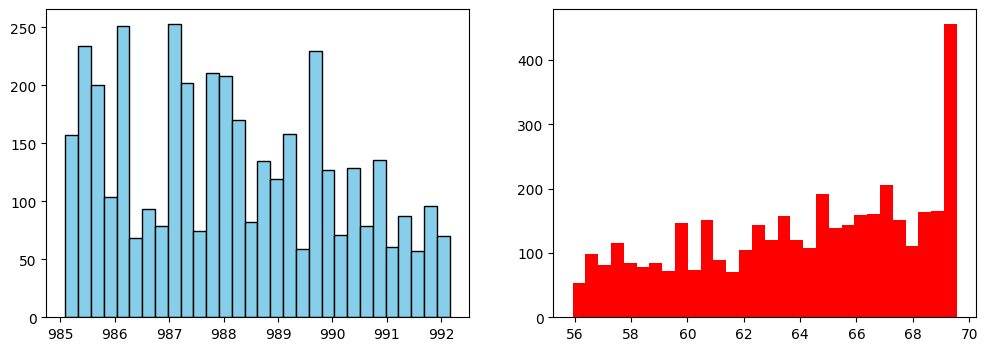

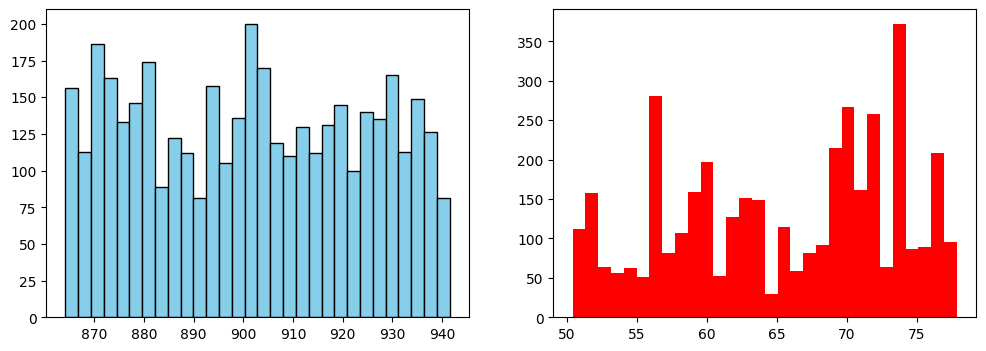

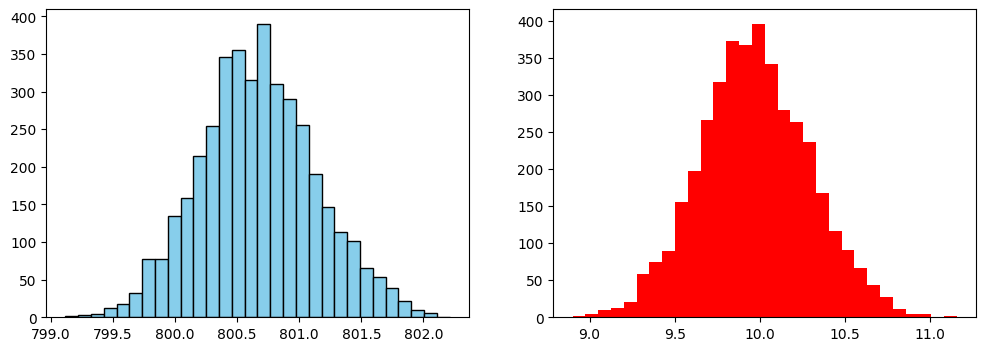

In [33]:
step_sizes = [0.001, 0.005, 0.02]

for step_size in step_sizes:
    mu_post, sigma_post = HMC(
        y=y, n=len(y),
        m=1000, s=20,
        a=10, b=2,
        step=step_size, L=12,
        initial_q=[1000, 11],
        nsamp=6000, nburn=2000
    )
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(mu_post, bins=30, color='skyblue', edgecolor='black')
    plt.subplot(1, 2, 2)
    plt.hist(sigma_post, bins=30, color='red')

4.

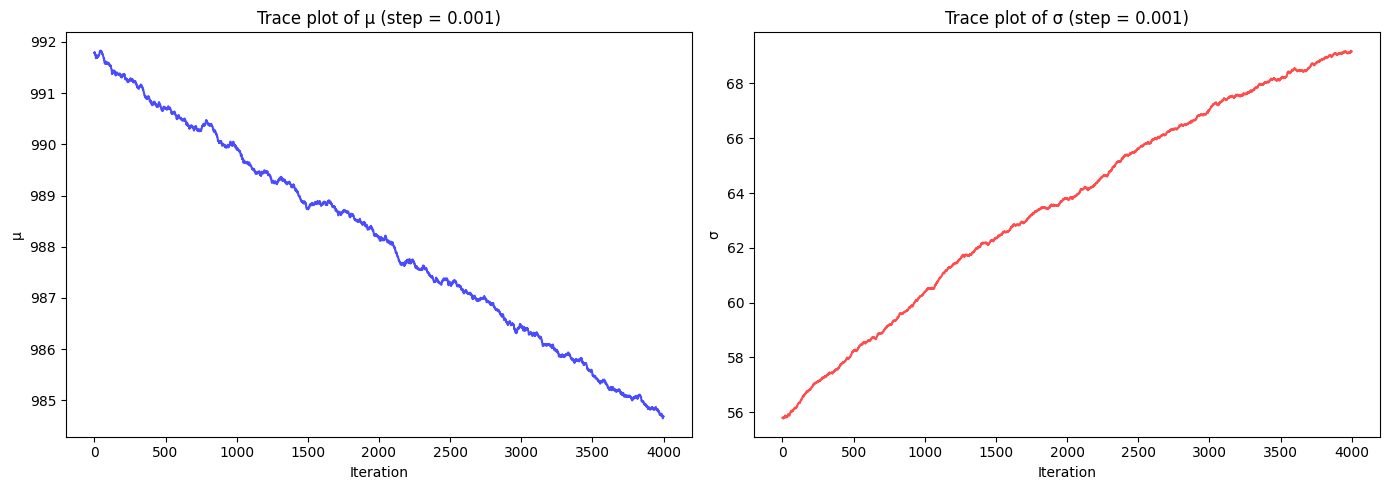

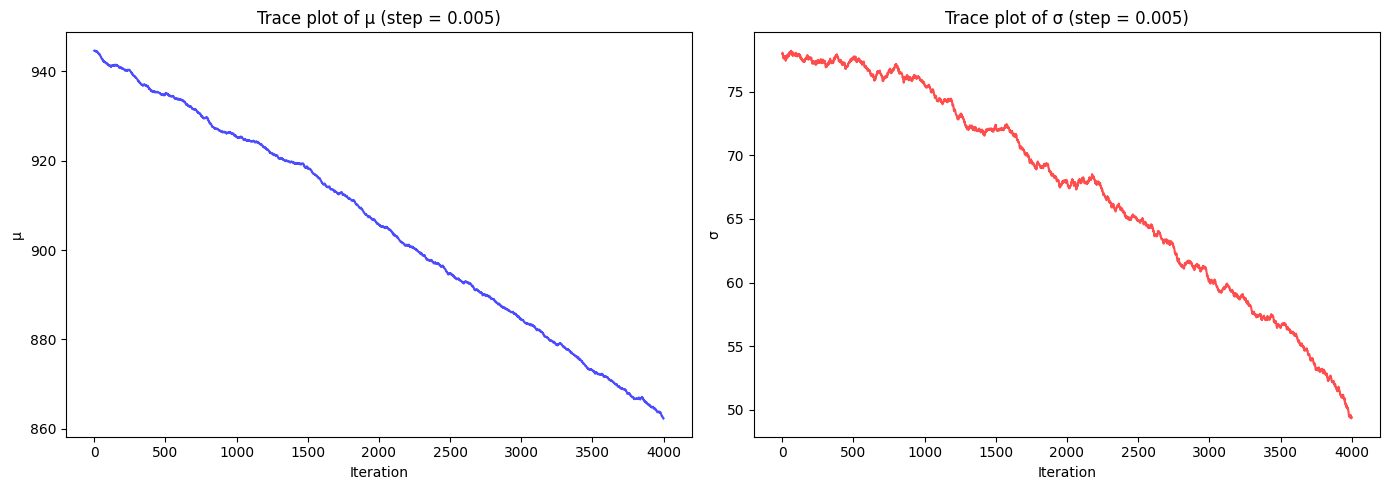

C:\Users\nakul\AppData\Local\Temp\ipykernel_30340\3150067047.py:43: RuntimeWarning: overflow encountered in exp
  accept_prob = np.exp(current_V + current_T - proposed_V - proposed_T)


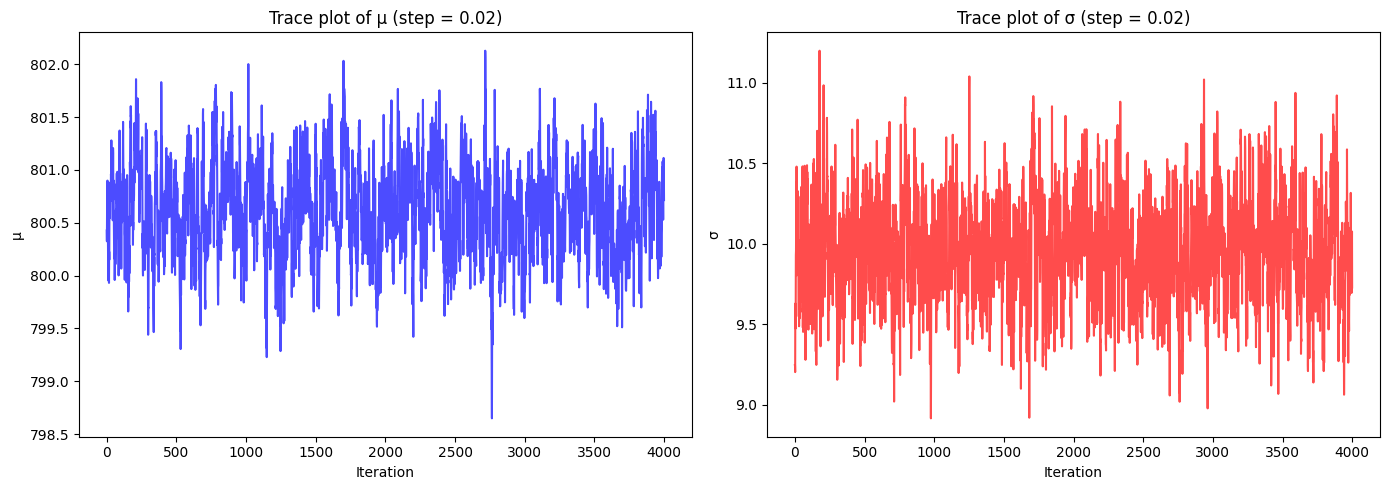

In [34]:
# Let's inspect the trace plots for each chain
step_sizes = [0.001, 0.005, 0.02]

for step_size in step_sizes:
    mu_post, sigma_post = HMC(
        y=y, n=len(y),
        m=1000, s=20,
        a=10, b=2,
        step=step_size, L=12,
        initial_q=[1000, 11],
        nsamp=6000, nburn=2000
    )

    # Trace plots
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(mu_post, color='blue', alpha=0.7)
    plt.title(f"Trace plot of μ (step = {step_size})")
    plt.xlabel("Iteration")
    plt.ylabel("μ")
    
    plt.subplot(1, 2, 2)
    plt.plot(sigma_post, color='red', alpha=0.7)
    plt.title(f"Trace plot of σ (step = {step_size})")
    plt.xlabel("Iteration")
    plt.ylabel("σ")

    plt.tight_layout()
    plt.show()


5.

C:\Users\nakul\AppData\Local\Temp\ipykernel_30340\3150067047.py:43: RuntimeWarning: overflow encountered in exp
  accept_prob = np.exp(current_V + current_T - proposed_V - proposed_T)


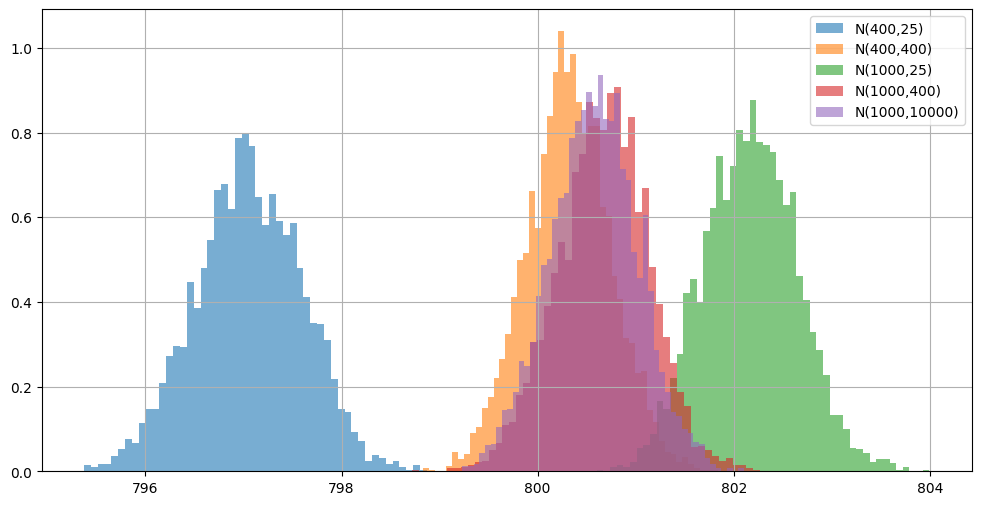

In [36]:
prior_settings = [
    (400, 5),
    (400, 20),
    (1000, 5),
    (1000, 20),
    (1000, 100),
]

mu_posteriors = {}
for m, s in prior_settings:
    mu_post, _ = HMC(
        y=y, n=len(y),
        m=m, s=s,
        a=10, b=2,
        step=0.02, L=12,
        initial_q=[1000, 11],
        nsamp=6000, nburn=2000
    )
    label = f"N({m},{s**2})"
    mu_posteriors[label] = mu_post

plt.figure(figsize=(12, 6))

for label, samples in mu_posteriors.items():
    plt.hist(samples, bins=50, density=True, alpha=0.6, label=label)

plt.legend()
plt.grid(True)
plt.show()


In [5]:
import random

def orient(a, b, c):
    return (b[1]-a[1])*(c[0]-b[0]) - (b[0]-a[0])*(c[1]-b[1])

def do_intersect(a, p, b, q):
    o1 = orient(b, q, a)
    o2 = orient(b, q, p)
    o3 = orient(a, p, b)
    o4 = orient(a, p, q)
    return o1 * o2 < 0 and o3 * o4 < 0

A = (0,0)
B = (1,0)
count = 0
N = 1000000

for _ in range(N):
    P = (random.uniform(0,1), random.uniform(0,1))
    Q = (random.uniform(0,1), random.uniform(0,1))
    if do_intersect(A, P, B, Q):
        count += 1

print("Estimated probability:", count/N)


Estimated probability: 0.250462
